### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템 ( LangGraph 사용하기)<br>
MessagesState를 사용하여 고객의 카페 관련 문의에 자동으로 응답하는 시스템을 만드세요. 고객이 메뉴, 가격, 추천 등에 대해 질문하면 카페 메뉴 데이터를 바탕으로 적절한 답변을 생성하는 시스템을 구현하세요.<br>

#### 학습 목표<br>
* 의미론적 검색: 사용자 문의를 직접 검색어로 활용하는 방법<br>
* MessagesState + Vector DB: 대화형 시스템과 벡터 검색 결합<br>
* 동적 정보 추출: 검색된 문서에서 구조화된 정보 추출<br>
* 실시간 검색 응답: 사용자 문의에 맞춤형 실시간 검색 결과 제공

#### 핵심 개념 설명<br>
* MessagesState: 메시지 리스트를 자동으로 관리하는 LangGraph의 특별한 상태 클래스<br>
* HumanMessage/AIMessage: 사용자와 AI의 메시지를 구분하는 LangChain의 메시지 클래스<br>
* 자연어 처리: 사용자의 텍스트 입력을 분석하여 의도를 파악하는 과정<br>
* 상태 확장: MessagesState를 상속받아 추가 필드를 포함하는 방법

#### 구현 단계별 가이드<br>
* 상태 정의: MessagesState를 상속받아 필요한 추가 필드 정의<br>
* 문의 분류 로직: 키워드 기반으로 사용자 문의 유형을 분류하는 함수 구현<br>
* 응답 생성 함수들: 각 문의 유형별로 적절한 응답을 생성하는 함수들 작성<br>
* 메시지 처리: 사용자의 마지막 메시지를 분석하고 적절한 응답 메시지 생성

#### 요구사항:<br>
* MessagesState 사용<br>
* 질문 유형 분류 (메뉴 문의, 가격 문의, 추천 요청)<br>
* 각 유형별 맞춤 응답 생성<br>
대화 이력 유지

### 환경 설정

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

### Messages State 정의

In [3]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class CafeState(MessagesState):
    documents: List[Document] = []
    query_type: str = ""

### RAG Chain 구성

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# cafe db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# prompt 정의
system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = cafe_db.as_retriever(
    search_kwargs={"k": 6}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "학생을 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

학생을 위한 메뉴를 추천해 드리겠습니다.

*   **카페라떼**: 5,500원으로 저렴한 가격에 즐길 수 있는 메뉴입니다. 에스프레소와 스팀 밀크가 조합된 고소한 커피입니다. 
*   **아이스 아메리카노**: 4,500원으로 저렴한 가격에 즐길 수 있는 메뉴입니다. 시원한 아이스 커피를 찾으시는 학생분들에게 안성맞춤인 메뉴입니다.

위 메뉴들은 저렴한 가격에 비해 맛과 퀄리티가 훌륭하여 학생들에게 인기가 많습니다.


### 노드(Node)

In [5]:
from typing import Dict

def classify_query(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content

    if "추천" in user_message:
        query_type = "recommend"
    elif "가격" in user_message or "얼마" in user_message:
        query_type = "price"
    elif "메뉴" in user_message or "있어" in user_message:
        query_type = "menu"
    else:
        query_type = "general"

    return {"query_type": query_type}

In [6]:
def search_cafe_docs(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content
    query_type = state.get("query_type", "general")

    # 기본값
    docs = []

    if query_type == "price":
        docs = cafe_db.similarity_search("메뉴 가격", k=5)

    elif query_type == "recommend":
        docs = cafe_db.similarity_search(user_message, k=3)
        if not docs:
            docs = cafe_db.similarity_search("인기 메뉴", k=3)

    elif query_type == "menu":
        docs = cafe_db.similarity_search(user_message, k=4)

    else:
        docs = cafe_db.similarity_search(user_message, k=4)

    return {"documents": docs}

In [7]:
import re
from langchain_core.documents import Document

def extract_menu_info(doc: Document) -> dict:
    content = doc.page_content
    menu_name = doc.metadata.get('menu_name', 'Unknown')
    
    price_match = re.search(r'₩([\d,]+)', content)
    description_match = re.search(r'설명:\s*(.+?)(?:\n|$)', content, re.DOTALL)

    return {
        "name": menu_name,
        "price": price_match.group(0) if price_match else "가격 정보 없음",
        "description": description_match.group(1).strip() if description_match else "설명 없음"
    }


In [8]:
from langchain_core.messages import AIMessage

def retrieve_and_respond(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content

    # RAG 체인 실행
    response = rag_chain.invoke(user_message)

    # 메시지 추가
    new_messages = state["messages"] + [AIMessage(content=response)]

    return {
        "messages": new_messages,
        "documents": state.get("documents", []),
        "query_type": state.get("query_type", ""),
    }

### 그래프(Graph) 구성

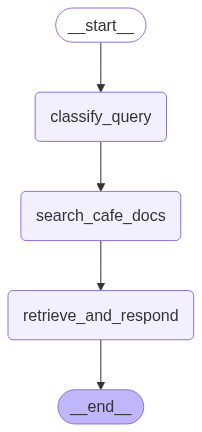

In [9]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(CafeState)

builder.add_node("classify_query", classify_query)
builder.add_node("search_cafe_docs", search_cafe_docs)
builder.add_node("retrieve_and_respond", retrieve_and_respond)

builder.add_edge(START, "classify_query")
builder.add_edge("classify_query", "search_cafe_docs")
builder.add_edge("search_cafe_docs", "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", END)

graph = builder.compile()


# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

### 그래프(Graph) 실행

In [11]:
from langchain_core.messages import HumanMessage
from pprint import pprint

initial_state = CafeState(
    messages=[HumanMessage(content="학생을 위한 메뉴를 추천해주세요.")],
    documents=[],
    query_type=""
)

final_state = graph.invoke(initial_state)

# 결과 출력
print("\n[사용자 질문]")
for msg in final_state["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"👉 {msg.content}")

print("\n[AI의 추천 응답]")
for msg in final_state["messages"]:
    if isinstance(msg, AIMessage):
        print(f"{msg.content}")

print("\n[참고한 메뉴 정보]")
for i, doc in enumerate(final_state["documents"], 1):
    name = doc.metadata.get("menu_name", "이름 없음")
    content = doc.page_content.strip()
    print(f"\n{i}. {name}")
    print(content)


[사용자 질문]
👉 학생을 위한 메뉴를 추천해주세요.

[AI의 추천 응답]
학생을 위한 메뉴를 추천해 드리겠습니다.

1. **예산 고려**: 학생의 경우 예산이 제한적일 수 있으므로, 가격대가 저렴한 메뉴를 고려해 볼게요.

2. **영양가 있는 메뉴**: 학생들은 성장기이므로 영양가 있는 메뉴를 선택하는 것이 좋아요.

3. **기호성**: 학생들의 기호를 고려하여 다양한 맛과 텍스처를 제공하는 메뉴를 선택할게요.

추천 메뉴:

*   **아이스 아메리카노**: 가격은 4,500원으로 저렴하면서도, 에스프레소의 진한 맛과 깔끔한 시원함을 즐길 수 있습니다. 
*   **카페라떼**: 5,500원으로, 에스프레소와 스팀 밀크가 조합된 부드럽고 풍부한 맛을 제공합니다. 
*   **바닐라 라떼**: 6,000원으로, 달콤한 바닐라 시럽이 추가된 라떼입니다. 

이 메뉴들은 가격대가 저렴하면서도, 학생들이 좋아할 만한 맛과 영양을 제공합니다.

[참고한 메뉴 정보]

1. 티라미수
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.

2. 바닐라 라떼
4. 바닐라 라떼
   • 가격: ₩6,000
   • 주요 원료: 에스프레소, 스팀 밀크, 바닐라 시럽
   • 설명: 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.

3. 카라멜 마키아토
5. 카라멜 마키아토
   • 가격: ₩6,500
   • 주요 원료: 에스프레소, 스팀 밀크, 카라멜 시럽, 휘핑크림
   • 설명: 스팀 밀크 위에 에스프레소를 부어 만든 후 카라멜 시럽과 휘핑크림으로 마무리한 달콤한 커피입니다